## Import dataset dari Google Drive

In [23]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [24]:
# DATASET_PATH = '/content/drive/MyDrive/Projects/NLP/dataset/dataset_preprocessed.csv'
# ABBREVIATIONS_PATH = '/content/drive/MyDrive/Projects/NLP/dataset/abbreviations_list.txt'
DATASET_PATH = '/content/drive/MyDrive/Kuliah/Semester 4/NLP/dataset/Preprocessing_HateSpeechDataset.csv'
ABBREVIATIONS_PATH = '/content/drive/MyDrive/Kuliah/Semester 4/NLP/dataset/abbreviations_list.txt'

# Import Libraries


In [25]:
%pip install pyspellchecker

In [26]:
import pandas as pd
import numpy as np
import pickle
import warnings
import json
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker

In [27]:
%matplotlib inline
sns.set(style='darkgrid')

warnings.filterwarnings('ignore')

In [28]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load Data


In [29]:
tweet_df = pd.read_csv(DATASET_PATH)
tweet_df = tweet_df.dropna()
tweet_df

,Clean,Label
0,currently appear engaged edit war according re...,0
1,know people think america change always racist...,0
2,full protection article excessive wikipedia tw...,0
3,added row popular vote table reflect estimate ...,0
4,arbor notification participated eye thread led...,0
...,...,...
141849,fact felt need use term demonstrates illiterat...,1
141850,gay name get take criticism loser question rea...,1
141851,wah tell communist faggot jeffrey fuck quit sh...,1
141852,vandalism please stop continue vandalize page ...,1


> Seperti yang ditunjukkan pada tabel diatas<br>
'**Clean**' berisikan tweet dari pengguna<br>
'**Label**' berisikan angka biner yang digunakan untuk melabelkan 'Content' ke deteksi ujaran kebencian<br>

# Feature Extraction and Modeling

### Feature Extraction

#### Split Data

In [30]:
train, test = train_test_split(tweet_df, test_size=0.3, stratify=tweet_df['Label'], random_state=42)

X_train = train['Clean'].values.astype(str)
y_train = train['Label']

X_test = test['Clean'].values.astype(str)
y_test = test['Label']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(99235,)
(42530,)
(99235,)
(42530,)


#### Feature Extraction (TF-IDF)

In [31]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train)

X_test = tfidf_vectorizer.transform(X_test)

### Modeling

In [32]:
def print_conf(y_test, result, classes, title='Confusion matrix'):
  conf_matrix = metrics.confusion_matrix(y_test, result)
  plt.figure(figsize=(6,6))
  sns.heatmap(conf_matrix,
              annot=True,
              xticklabels=classes,
              yticklabels=classes,
              cmap="Blues",
              fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title(title)
  plt.show()

In [33]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)

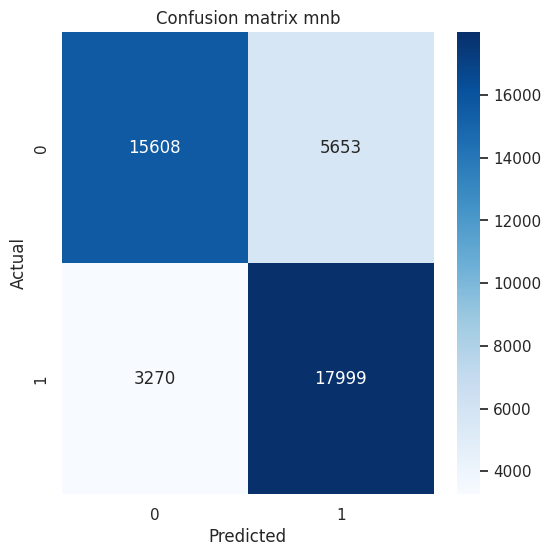

In [34]:
print_conf(y_test, y_pred_mnb, [0, 1], title="Confusion matrix mnb")

In [64]:
print(metrics.classification_report(y_test, y_pred_mnb))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     21261
           1       0.76      0.85      0.80     21269

    accuracy                           0.79     42530
   macro avg       0.79      0.79      0.79     42530
weighted avg       0.79      0.79      0.79     42530



# Save Model To Pickle

In [65]:
pick_insert = open('/content/drive/MyDrive/Kuliah/Semester 4/NLP/Pickle/MultinomialNaiveBayes.pkl','wb')
pickle.dump(mnb, pick_insert)
pick_insert.close()

pick_insert = open('/content/drive/MyDrive/Kuliah/Semester 4/NLP/Pickle/TFIDFVectorizer.pkl','wb')
pickle.dump(tfidf_vectorizer, pick_insert)
pick_insert.close()

#Predict New Data

# Preprocess New Data Function

In [66]:
def load_abbreviations(file_path):
    with open(file_path, 'r') as file:
        abbreviations = json.load(file)
    return abbreviations

abbreviations = load_abbreviations(ABBREVIATIONS_PATH)

def fix_slang(text):
    if isinstance(text, str):
        words = text.split()
        fixed_words = [abbreviations[word.lower()] if word.lower() in abbreviations else word for word in words]
        return ' '.join(fixed_words)
    return text

In [67]:
spell = SpellChecker()

def correct_typos(text):
    corrected_text = []
    for word in text.split():
        corrected_word = spell.correction(word)
        corrected_text.append(corrected_word)
    return ' '.join(corrected_text)

In [68]:
def clean_text(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub('\n', '', text)
    text = re.sub('RT', '', text)
    text = re.sub("[^a-zA-Z^']", " ", text)
    text = re.sub(" {2,}", " ", text)
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

In [69]:
def tokenize_text(text):
    return word_tokenize(text)

In [70]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(token_list):
    return [lemmatizer.lemmatize(token) for token in token_list]

In [71]:
eng_stopwords = stopwords.words('english')

def remove_stopwords(token_list):
    return [word for word in token_list if word not in eng_stopwords]

# Predict

In [72]:
input_tweet = [
    "Black people are losers",
    "You're a good person.",
    "I h8 u so much, you're a worthless piece of shit with a vagina!",
    "Great job on the project, keep it up!"
]

def preProcessText(input_tweet):
    new_tweets = []
    for tw in input_tweet:
        print(f"Input Text: {tw}")
        tw_slang = fix_slang(tw)
        print(f"Fix Slang: {tw_slang}")
        tw_typo = correct_typos(tw_slang)
        print(f"Correct Typo: {tw_typo}")
        tw_clean = clean_text(tw_typo)
        print(f"Clean Text: {tw_clean}")
        tw_tokenize = tokenize_text(tw_clean)
        print(f"Tokenize: {tw_tokenize}")
        tw_lemma = lemmatize_tokens(tw_tokenize)
        print(f"Lemmatize Tokens: {tw_lemma}")
        tw_stopwords = remove_stopwords(tw_lemma)
        print(f"Remove Stopwords: {tw_stopwords}")
        tw_final = ' '.join(tw_stopwords)
        new_tweets.append(tw_final)
        print("\n")
    return new_tweets

def predictNewData(input_tweet):
    processed_tweets = preProcessText(input_tweet)

    pick_read = open('/content/drive/MyDrive/Kuliah/Semester 4/NLP/Pickle/MultinomialNaiveBayes.pkl','rb')
    model = pickle.load(pick_read)
    pick_read.close()

    pick_read = open('/content/drive/MyDrive/Kuliah/Semester 4/NLP/Pickle/TFIDFVectorizer.pkl','rb')
    saved_tfidf = pickle.load(pick_read)
    pick_read.close()

    vectorized_tweets = saved_tfidf.transform(processed_tweets)
    input_prediction = model.predict(vectorized_tweets.toarray())

    for i in range(len(input_tweet)):
        print(f"\nInput Text: {input_tweet[i]}")
        print(f"Processed Text: {processed_tweets[i]}")
        if input_prediction[i] == 1:
            print("Prediction: Hate Speech!\n")
        else:
            print("Prediction: Not a Hate Speech.\n")

predictNewData(input_tweet)


Input Text: Black people are losers
Fix Slang: Black people are losers
Correct Typo: Black people are losers
Clean Text: black people are losers
Tokenize: ['black', 'people', 'are', 'losers']
Lemmatize Tokens: ['black', 'people', 'are', 'loser']
Remove Stopwords: ['black', 'people', 'loser']


Input Text: You're a good person.
Fix Slang: you are a good person.
Correct Typo: you are a good person
Clean Text: you are a good person
Tokenize: ['you', 'are', 'a', 'good', 'person']
Lemmatize Tokens: ['you', 'are', 'a', 'good', 'person']
Remove Stopwords: ['good', 'person']


Input Text: I h8 u so much, you're a worthless piece of shit with a vagina!
Fix Slang: I hate you so much, you are a worthless piece of shit with a vagina!
Correct Typo: I hate you so much you are a worthless piece of shit with a vagina
Clean Text: i hate you so much you are a worthless piece of shit with a vagina
Tokenize: ['i', 'hate', 'you', 'so', 'much', 'you', 'are', 'a', 'worthless', 'piece', 'of', 'shit', 'with', 